In [73]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from adabmDCA.utils import get_device, get_dtype

In [33]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

device = get_device("")
dtype = get_dtype("float64")

Running on CPU


In [6]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [114]:
del sequences

In [8]:
sequences_oh = [one_hot(seq).to(dtype=dtype, device=device) for seq in sequences]

In [99]:
fi_tuple, fij_tuple, total_reads_tuple = zip(*[utils.frequences_from_sequences_oh(s) for s in sequences_oh])
fi = torch.stack(fi_tuple)  # n_rounds, L, q
fij = torch.stack(fij_tuple)      # n_rounds, L, q, L, q
total_reads = torch.tensor(total_reads_tuple, dtype=dtype, device=device)
n_rounds, L, q = fi.size()

In [13]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])

In [100]:
L, q = sequences_oh[0][0].shape
k = torch.zeros(L, q, dtype=dtype, device=device)
k = torch.log(fi[0])
h = torch.zeros(L, q, dtype=dtype, device=device)
J = torch.zeros(L, q, L, q, dtype=dtype, device=device)

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor([[1],[1]])

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
indep = energy_models.IndepSites(h)
ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [101]:
batch_size = 10**6
datasets = [data_loading.SelexRoundDataset(seq_oh) for seq_oh in sequences_oh]
n_rounds = len(datasets) 
data_loaders = [torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True) for ds in datasets]

In [102]:
n_chains = 10**3

chains = init_chains(n_rounds, n_chains, L, q, device, dtype)
log_weights = torch.zeros(n_rounds, n_chains, device=device, dtype=dtype)

In [103]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [104]:
import importlib
importlib.reload(training)
importlib.reload(callback)

<module 'callback' from '/Users/scrotti/Aptamer2025py/callback.py'>

In [105]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [109]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 500

%lprun -f training.train training.train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson, callbacks=callbacks)

 0.00%[                              ] Epoch: 0/500 [00:00, ?it/s]

Timer unit: 1e-09 s

Total time: 29778.7 s
File: /Users/scrotti/Aptamer2025py/training.py
Function: train at line 71

Line #      Hits         Time  Per Hit   % Time  Line Contents
    71                                           def train(
    72                                               model: selex_distribution.MultiRoundDistribution,
    73                                               data_loaders,
    74                                               total_reads,
    75                                               chains: torch.Tensor,
    76                                               n_sweeps: int,
    77                                               lr: float,    
    78                                               max_epochs: int,
    79                                               target_pearson = 0.999,
    80                                               thresh_slope = 1e-2,
    81                                               l2reg: float = 0.0,
    82            

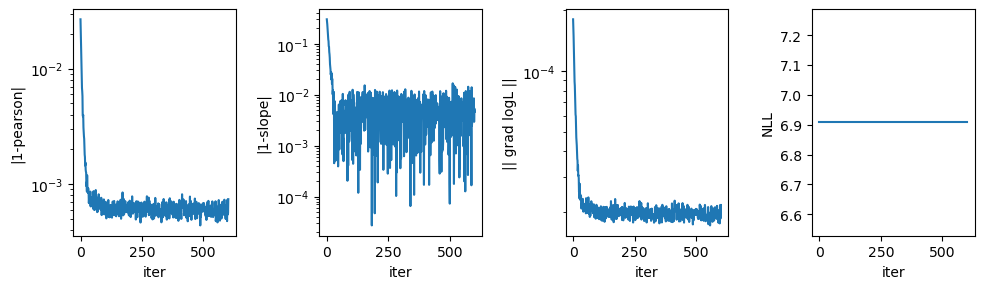

In [112]:
callbacks[0].plot();

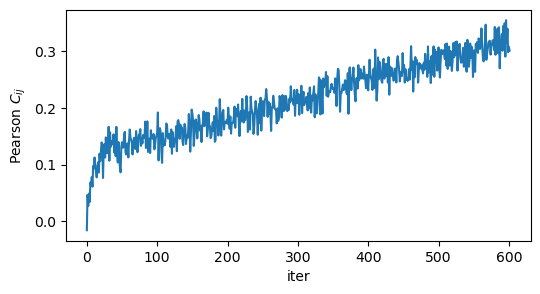

In [113]:
callbacks[1].plot();